##Installing and loading libraries

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  1 06:35:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#tensorboard dev
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp

In [3]:
import numpy as np
import glob2
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil
import tensorflow as tf
import glob2
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from tqdm import tqdm
import itertools
#import mlflow
from sklearn.metrics import cohen_kappa_score

import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, Optimizer
from keras.callbacks import *
from keras_preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.activations import elu

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization

from PIL import Image
import cv2

from keras.models import Model
from keras.layers import Input, Dropout, Activation, MaxPooling2D, Flatten,GlobalMaxPooling2D

##Retrieving Data

In [4]:
!rm -r /content/sample_data

In [5]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
weird_images = ['ID11','ID12','ID14','ID23','ID24','ID27','ID30','ID33','ID44','ID50','ID53','ID66','ID78','ID83']

for image in weird_images:
  shutil.rmtree(f'/content/crops/crop_{image}_L1')
  try:
    shutil.rmtree(f'/content/crops/crop_{image}_L2')
    shutil.rmtree(f'/content/crops/crop_{image}_L3')
    shutil.rmtree(f'/content/crops/crop_{image}_L4')
    shutil.rmtree(f'/content/crops/crop_{image}_L5')
  except:
    pass

#Classify pathological & non pathological

In [ ]:
nonpatho_patients = ['ID4_L1', 'ID4_L2', 'ID6_L1', 'ID6_L2' 'ID12_L5', 'ID14_L1', 'ID14_L2', 'ID16_L2', 'ID17_L2', 
                     'ID19_L1', 'ID19_L2', 'ID19_L3', 'ID21_L1', 'ID22_L1', 'ID22_L2','ID22_L3', 'ID24_L1', 'ID26_L1', 'ID28_L1', 'ID28_L2', 
                     'ID30_L1', 'ID31_L1', 'ID31_L2', 'ID32_L1', 'ID33_L1', 'ID34_L1', 'ID37_L1', 'ID40_L1', 'ID45_L2', 'ID48_L2', 'ID50_L1', 
                     'ID54_L1', 'ID54_L2', 'ID56_L1', 'ID56_L2', 'ID62_L2', 'ID64_L1', 'ID65_L1', 'ID66_L1', 'ID68_L1', 'ID71_L1', 'ID71_L2', 
                     'ID71_L3', 'ID71_L4', 'ID72_L1', 'ID78_L1', 'ID80_L1', 'ID82_L1', 'ID83_L1', 'ID85_L1']

In [ ]:
for file in glob2.glob('/content/crops/*'):
  patientID = file.split('/')[3]
  patientID = patientID.lstrip('crop_')
  filename = file.split('/')[3]
  filename = filename.lstrip('crop_')
  if patientID in nonpatho_patients:
    shutil.copytree(file, f'/content/nonpatho/{filename}')
  else:
    shutil.copytree(file, f'/content/patho/{filename}')

In [ ]:
nonpatho_nodes = glob2.glob('/content/nonpatho/*')
patho_nodes = glob2.glob('/content/patho/*')
print(f'patho nodes: {len(patho_nodes)},\nnon patho nodes:{len(nonpatho_nodes)}')

patho nodes: 100,
non patho nodes:34


In [105]:
!cp /content/gdrive/MyDrive/Donnes_patients/Tumor_diation_512_class.zip /content/
!unzip -q /content/Tumor_diation_512_class.zip

In [109]:
!rm -r /content/data
!rm -r /content/test_data
!rm -r new_data
!mkdir new_data
!mkdir test_data

In [107]:
for image in glob2.glob('/content/data/train/patho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/new_data/{new_name}_class1.png')

In [108]:
for image in glob2.glob('/content/data/train/nonpatho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/new_data/{new_name}_class0.png')

In [ ]:
for image in glob2.glob('/content/data/validation/patho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/new_data/{new_name}_class1.png')

for image in glob2.glob('/content/data/validation/nonpatho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/new_data/{new_name}_class0.png')

for image in glob2.glob('/content/data/test/patho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/test_data/{new_name}_class1.png')

for image in glob2.glob('/content/data/test/nonpatho/*'):
  name = image.split('/')[5]
  new_name = name.split('.')[0]
  shutil.copy(image, f'/content/test_data/{new_name}_class0.png')

In [4]:
files = glob2.glob('/content/new_data/*')
print(len(files))

3935


In [5]:
test_files = glob2.glob('/content/test_data/*')
print(len(test_files))

133


In [6]:
count_patho =0 
for file in files:
    if file[-5] == '1':
        count_patho+=1
print(f'patho images: {count_patho}')

patho images: 3145


In [7]:
count =0 
for file in files:
    if file[-5] == '0':
        count+=1
print(f'non patho images: {count}')

non patho images: 790


In [8]:
count_patho =0 
for file in test_files:
    if file[-5] == '1':
        count_patho+=1
print(f'test_patho images: {count_patho}')

count =0 
for file in test_files:
    if file[-5] == '0':
        count+=1
print(f'test_non patho images: {count}')

test_patho images: 93
test_non patho images: 40


In [11]:
#Handling class imbalance
def load_balanced_data(files, size, start_index):
    half_size = int(size/2)
    count=0
    res = []
    y = []
    for file in files[start_index:]:
        if (count!=half_size):
            if file[-5] == '1' and file.endswith(".png"):
                img = load_img(file, target_size = (456,456))
                pixels = img_to_array(img)
                res.append(pixels)
                y.append(1)
                count += 1      
        else:
            break
                
    for file in files[start_index:]:
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (456,456))
                pixels = img_to_array(img)
                res.append(pixels)
                y.append(0)
                count -= 1
        else:
            break
    return np.stack(res), y

In [12]:
X_train2, y_train2 = load_balanced_data(files, 2000,0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


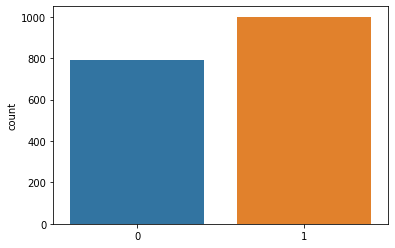

In [13]:
import seaborn as sns
sns.countplot(y_train2)

In [14]:
x_test2, y_test2 = load_balanced_data(test_files, 528, 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


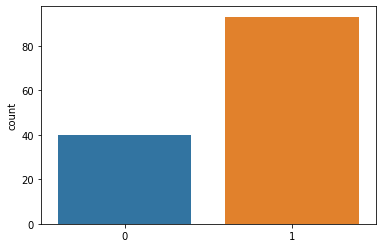

In [15]:
sns.countplot(y_test2)

In [17]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization,GlobalMaxPooling2D
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import efficientnet.tfkeras as efn

In [19]:
def def_model2(inp_shape = (456,456,3)):
  model = keras.models.Sequential([
                                   efn.EfficientNetB5(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=inp_shape),
                                   GlobalMaxPooling2D(),
                                   Dense(1, activation = "sigmoid")          
                                   ])
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics = ['acc',keras.metrics.AUC(name='auc')])
  return model

In [20]:
model2 = def_model2()
model2.summary()

115523584/115515256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 15, 15, 2048)     28513520  
 )                                                               
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________


In [21]:
from keras.preprocessing.image import ImageDataGenerator

In [22]:
datagen = ImageDataGenerator(height_shift_range=0.2,
                            width_shift_range=0.2,
                             )
train_generator = datagen.flow(X_train2, y_train2, batch_size=4)
val_generator = datagen.flow(x_test2, y_test2, batch_size=4)

In [23]:
callback = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',factor=0.25,patience=2, verbose=1,min_delta=0.0001,cooldown=0,min_lr=0.00001, mode='auto',
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

In [24]:
history2 = model2.fit(train_generator, validation_data=val_generator, epochs = 30,
                     callbacks=[es,callback])
model2.save('model_EfficientNetB32.h5')

Epoch 1/30
448/448 [==============================] - 240s 462ms/step - loss: 1.1729 - acc: 0.5821 - auc: 0.5852 - val_loss: 0.5333 - val_acc: 0.8797 - val_auc: 0.9548 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - 201s 448ms/step - loss: 0.6583 - acc: 0.5855 - auc: 0.6403 - val_loss: 0.2868 - val_acc: 0.9774 - val_auc: 0.9988 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - 203s 452ms/step - loss: 0.6499 - acc: 0.6061 - auc: 0.6550 - val_loss: 0.1900 - val_acc: 0.9774 - val_auc: 0.9997 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - 202s 450ms/step - loss: 0.6218 - acc: 0.6564 - auc: 0.7079 - val_loss: 0.5526 - val_acc: 0.6617 - val_auc: 0.6315 - lr: 0.0010
Epoch 5/30
448/448 [==============================] - 202s 450ms/step - loss: 0.6240 - acc: 0.6520 - auc: 0.7041 - val_loss: 1.4649 - val_acc: 0.6992 - val_auc: 0.6320 - lr: 0.0010
Epoch 6/30
448/448 [==============================] - 203s 453ms/step - loss: 0.6182 - acc: 0.6

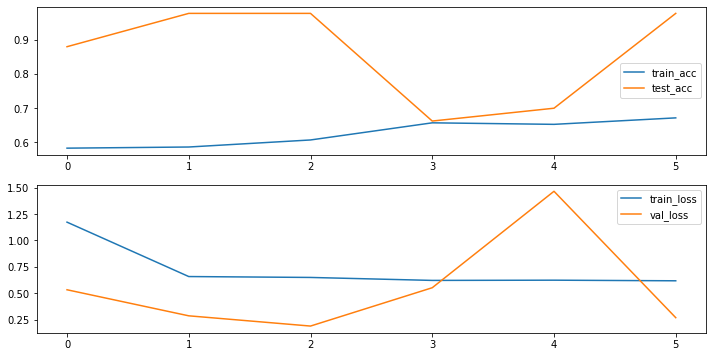

In [27]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history2.history['acc'], label="train_acc")
plt.plot(history2.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label = "train_loss")
plt.plot(history2.history['val_loss'], label = "val_loss")
plt.legend()

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        40
           1       0.97      1.00      0.98        93

    accuracy                           0.98       133
   macro avg       0.98      0.96      0.97       133
weighted avg       0.98      0.98      0.98       133

AUC Score :  1.0


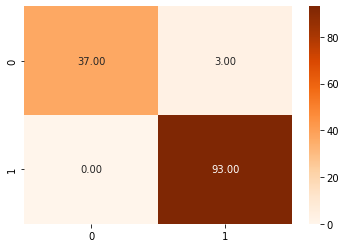

In [26]:
pred = model2.predict(x_test2)

res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)
        
from sklearn.metrics import classification_report, confusion_matrix
conf = confusion_matrix(y_test2, res)
sns.heatmap(conf,annot=True,fmt='0.2f',cmap='Oranges',xticklabels=['0','1'],yticklabels=['0','1'])
print(classification_report(y_test2, res))

from sklearn.metrics import roc_curve,roc_auc_score
pred_prob = pred

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test2, pred_prob[:], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test2))]
p_fpr, p_tpr, _ = roc_curve(y_test2, random_probs, pos_label=1)

# auc score
auc_score = roc_auc_score(y_test2, pred_prob[:])

print('AUC Score : ',auc_score)

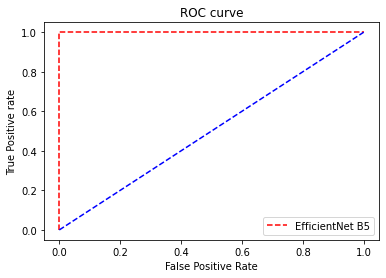

In [28]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='EfficientNet B5')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

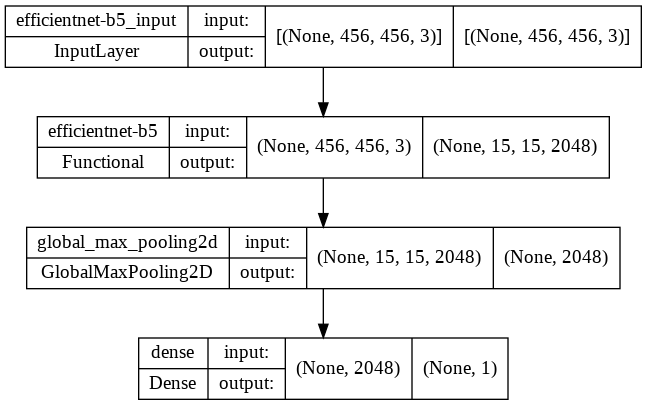

In [29]:
# saving the model architecture as png image
from keras.utils.vis_utils import plot_model
plot_model(model2,to_file='EnetB5.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='EnetB5.png')